In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [2]:
train_df = pd.read_csv('train_for_2012.csv')
train_df.shape

(837913, 44)

In [3]:
test_df = pd.read_csv('test_for_2012.csv')
test_df.shape

(185639, 44)

In [4]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [32]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

(237711, 45)


0.23224125398611892

In [5]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [6]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [9]:
from harness_functions import pre_process

In [11]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [12]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {}
}

In [13]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile


## Train algorithm

In [16]:
### features for first firm
features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',
]


In [18]:
### features for recurring firms
rec_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',

]

In [21]:
formula = 'default ~ '+' + '.join(features)
#formula = 'default ~ '+' + '.join(rec_features)
formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [38]:
algo = smf.probit

model = algo(formula, data = train_data_proc) 
fitted_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.060405
         Iterations 9


### Model results

In [39]:
print(fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               837913
Model:                         Probit   Df Residuals:                   837904
Method:                           MLE   Df Model:                            8
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.1590
Time:                        18:38:38   Log-Likelihood:                -50615.
converged:                       True   LL-Null:                       -60183.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.5319      0.042    -84.079      0.000      -3.614      -3.450
asst_tot_quantile_values               29.0236      2.59

In [40]:
print(fitted_model.get_margeff().summary())

       Probit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
asst_tot_quantile_values                0.8545      0.077     11.148      0.000       0.704       1.005
financial_leverage_quantile_values      0.0828      0.002     34.136      0.000       0.078       0.088
profitability_ratio_quantile_values     0.1074      0.003     39.068      0.000       0.102       0.113
net_income_growth_quantile_values       0.1138      0.006     18.616      0.000       0.102       0.126
quick_ratio_v2_quantile_values          0.4579      0.023     19.623      0.000       0.412       0.504
sales_growth_quantile_values            0.2725      0.012     22.399      0.000       0.249       0.296
cash_assets_rati

## Process test data

In [41]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

In [42]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile


In [51]:
test_data_proc.head()

,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,sales,sales_growth,sales_growth_quantile,sales_growth_quantile_values,cash_assets_ratio,cash_assets_ratio_quantile,cash_assets_ratio_quantile_values,dscr,dscr_quantile,dscr_quantile_values
0,21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,...,319790.0,0.0,19,0.010524,0.003496,18,0.016469,-11.487373,4,0.069459
1,50,1650282,2012-12-31,27.0,SRL,25.0,NaT,2012,14380.0,1151565.0,...,17401237.0,0.0,19,0.010524,0.297391,50,0.007937,11.098045,39,0.004833
2,57,1930130,2012-12-31,13.0,SRL,43.0,NaT,2012,5462.0,361323.0,...,2150214.0,0.0,19,0.010524,0.339159,50,0.007937,95.801490,47,0.005132
3,70,2040061,2012-12-31,6.0,SPA,46.0,NaT,2012,31764.0,2418009.0,...,3451023.0,0.0,19,0.010524,0.022331,31,0.013247,3.483102,28,0.006206
4,83,2340420,2012-12-31,42.0,SRL,47.0,NaT,2012,273.0,51407.0,...,2060412.0,0.0,19,0.010524,0.106596,43,0.008831,-5.712281,5,0.069459


In [52]:
test_predictions = fitted_model.predict(test_data_proc)

In [53]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions

In [54]:
test_results.head()

,default,predictions
0,0,0.051163
1,0,0.003326
2,0,0.003840
3,0,0.005677
4,0,0.016024


In [55]:
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

np.float64(0.8267216449669654)

ROC AUC 0.8267216449669654


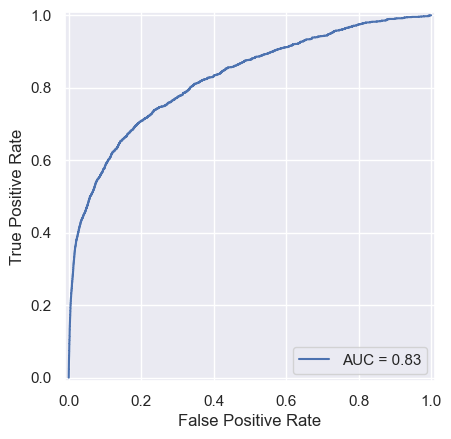

In [56]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [50]:
train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)